## Second Attempt: DataCamp template

## Problem Framing and Technical Summary

We are a not for profit consummer advisory company independently testing, reviewing, investigating products and financial products, and advising on value for money insurance.

## 1. Importing Libraries

In [48]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import tree
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

## 2.Exploratory Data Analysis
### 2.1 Load in cleaned csv

In [2]:
df = pd.read_csv('wisconsin.csv')
df.drop(df.columns[0], axis=1, inplace=True)
del df['YEAR']
df.to_pickle('./dataframe.pkl')

In [3]:
df.head(5)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,...,WEATHER_DELAY,airline_full_name,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_CITY,DESTINATION_STATE,DESTINATION_LATITUDE,DESTINATION_LONGITUDE
0,7,1,3,OO,3423,N170SY,MKE,SEA,1605,1603.0,...,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
1,7,2,4,OO,3423,N171SY,MKE,SEA,1605,1600.0,...,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
2,7,3,5,OO,3423,N170SY,MKE,SEA,1605,1605.0,...,0.0,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
3,7,4,6,OO,3423,N173SY,MKE,SEA,1605,1558.0,...,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931
4,7,5,7,OO,3423,N171SY,MKE,SEA,1605,1600.0,...,NaN,Skywest Airlines Inc.,Milwaukee,WI,42.94722,-87.89658,Seattle,WA,47.44898,-122.30931


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51376 entries, 0 to 51375
Data columns (total 39 columns):
MONTH                    51376 non-null int64
DAY                      51376 non-null int64
DAY_OF_WEEK              51376 non-null int64
AIRLINE                  51376 non-null object
FLIGHT_NUMBER            51376 non-null int64
TAIL_NUMBER              51320 non-null object
ORIGIN_AIRPORT           51376 non-null object
DESTINATION_AIRPORT      51376 non-null object
SCHEDULED_DEPARTURE      51376 non-null int64
DEPARTURE_TIME           50151 non-null float64
DEPARTURE_DELAY          50151 non-null float64
TAXI_OUT                 50122 non-null float64
WHEELS_OFF               50122 non-null float64
SCHEDULED_TIME           51376 non-null float64
ELAPSED_TIME             49994 non-null float64
AIR_TIME                 49994 non-null float64
DISTANCE                 51376 non-null int64
WHEELS_ON                50094 non-null float64
TAXI_IN                  50094 non-null flo

### 2.2 Visual Analysis
#### 2.2.1 Showing Flight Times by Airport of Origin

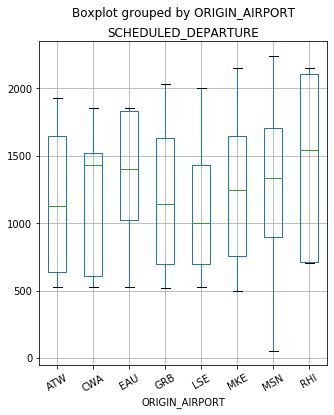

In [5]:
df.boxplot('SCHEDULED_DEPARTURE','ORIGIN_AIRPORT',rot = 30,figsize=(5,6))

#### 2.2.2 Graph Function

In [6]:
def bar_plot(col):

    col_count = df[col].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(col_count.index, col_count.values, alpha=0.8)
    plt.title('Frequency Distribution of ' + str(col))
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(col, fontsize=12)
    plt.show()
    

#### 2.2.3 Flights by Airline

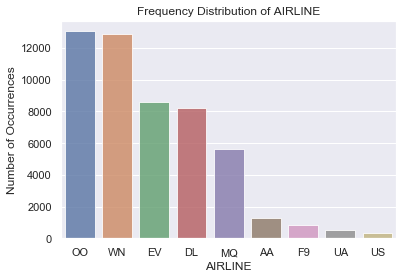

In [7]:
bar_plot('AIRLINE')

#### 2.2.4 Flights by Airport of Origin

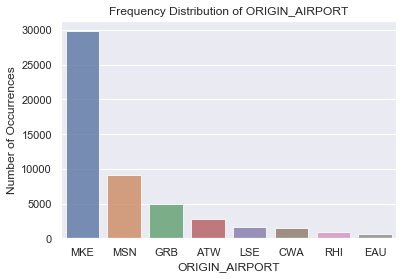

In [8]:
bar_plot('ORIGIN_AIRPORT')

#### 2.2.5 Flights by Airport of Origin

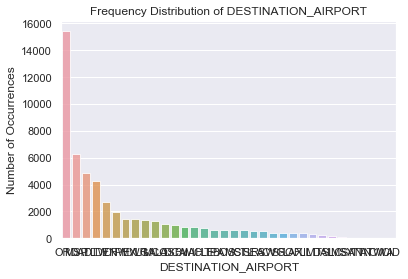

In [9]:
bar_plot('DESTINATION_AIRPORT')

### 2.3 Class Imbalance Exploration

In [10]:
%load_ext autoreload
%autoreload
from clockwork_orange import delay_cutoff_plot, classifier_plot

### 2.2.1 Class Imbalance as a function of "delayed" contractual definition 

Insurance policies will have a definition of a delay, a threshold beneath which they will not pay claims.  Tight definitions of a delay can lead to moral hazard, adverse selection and underprovision.  For this reason insurance contracts have buffer between a mathematical definition of delayed and the policy definition. As the definition of "delayed" changes between insurers and between policies this has an interesting impact on class balance. 

##### Military Delay: Ontime is 4 minutes early (negative delay):
For a policy threshold delay of -4 minutes, half of planes take off 4 minutes early or earlier, and half of planes take off 3 minutes early or later. If this was the boilerplate definition of delayed in insurance contracts there would be no class imbalance, but insurance would be very expensive'

##### Mathematical Delay: 
73% of planes take off ontime or earlier, and 27% of planes take off one minute or later.

##### Insurance Delay Minimum:
92.6% of planes take off before the 30 min delay mark, 7.4% are later than 30 minutes. You are now entering the insurance zone.

##### Insurance Payout Zone:
95% of planes take off within 1 hour of their scheduled time, meaning 5% are more than one hour delayed.
The charts below explore the class imbalance at increasing intervals of delay.

Wall time: 0 ns


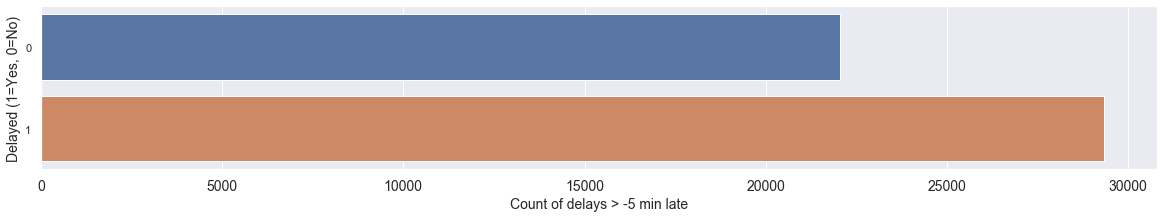

##########################################
Total flights   :  51376
Flights delayed :  29322
Flights ontime  :  22054
##########################################
Flights delayed :  57.073 %
Flights ontime  :  42.927 %
##########################################


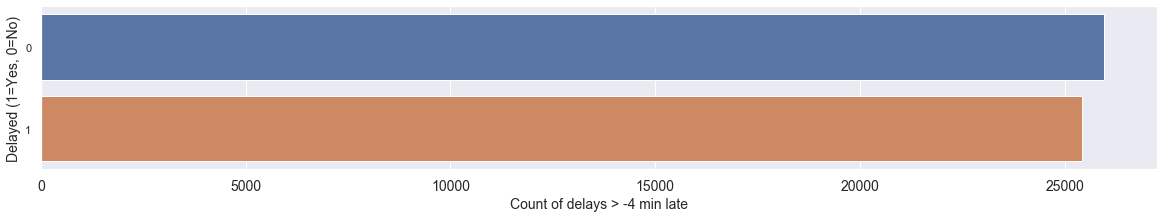

##########################################
Total flights   :  51376
Flights delayed :  25426
Flights ontime  :  25950
##########################################
Flights delayed :  49.49 %
Flights ontime  :  50.51 %
##########################################


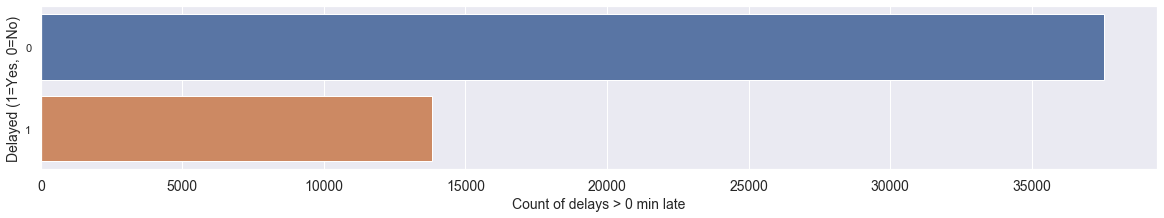

##########################################
Total flights   :  51376
Flights delayed :  13831
Flights ontime  :  37545
##########################################
Flights delayed :  26.921 %
Flights ontime  :  73.079 %
##########################################


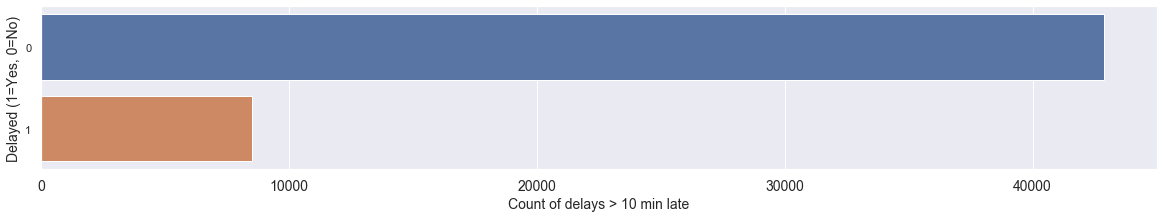

##########################################
Total flights   :  51376
Flights delayed :  8509
Flights ontime  :  42867
##########################################
Flights delayed :  16.562 %
Flights ontime  :  83.438 %
##########################################


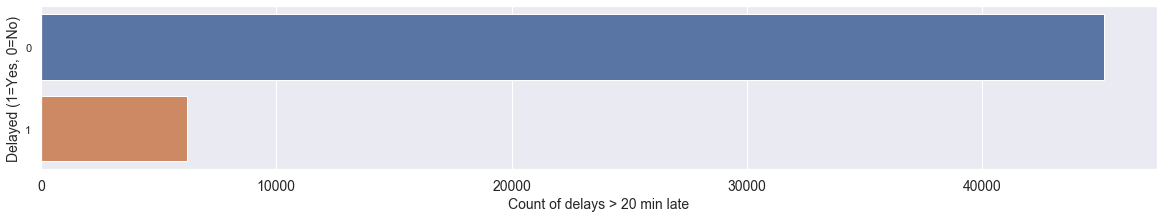

##########################################
Total flights   :  51376
Flights delayed :  6223
Flights ontime  :  45153
##########################################
Flights delayed :  12.113 %
Flights ontime  :  87.887 %
##########################################


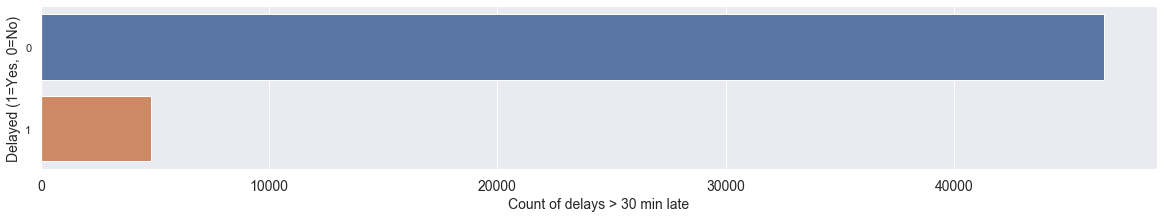

##########################################
Total flights   :  51376
Flights delayed :  4815
Flights ontime  :  46561
##########################################
Flights delayed :  9.372 %
Flights ontime  :  90.628 %
##########################################


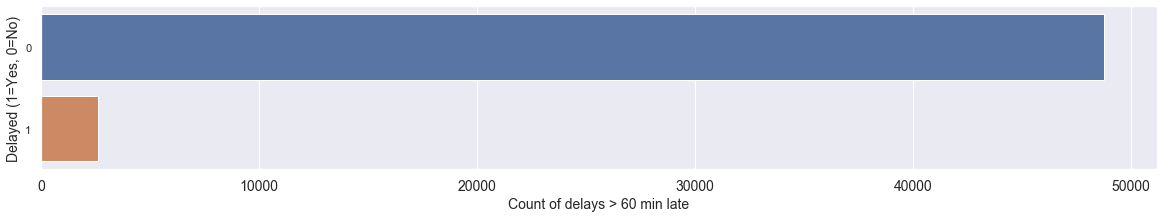

##########################################
Total flights   :  51376
Flights delayed :  2617
Flights ontime  :  48759
##########################################
Flights delayed :  5.094 %
Flights ontime  :  94.906 %
##########################################


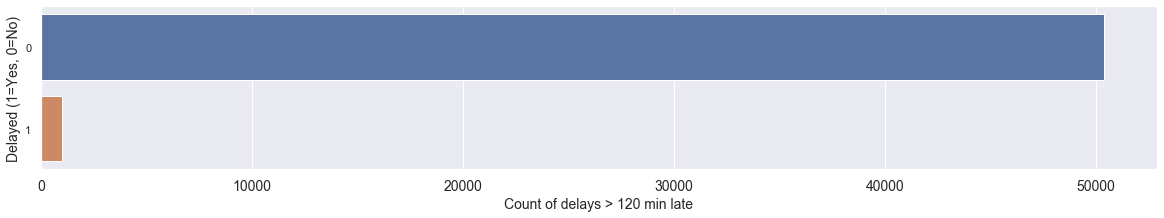

##########################################
Total flights   :  51376
Flights delayed :  1025
Flights ontime  :  50351
##########################################
Flights delayed :  1.995 %
Flights ontime  :  98.005 %
##########################################


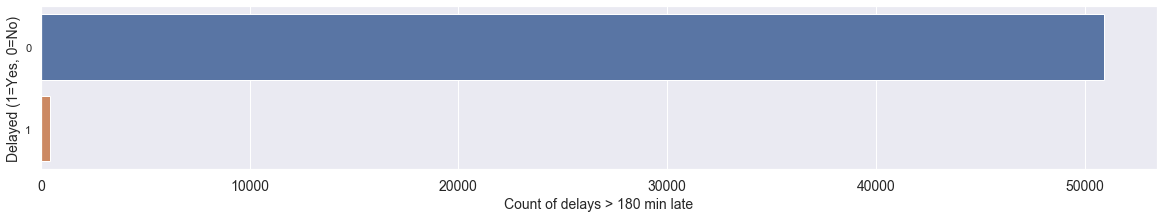

##########################################
Total flights   :  51376
Flights delayed :  461
Flights ontime  :  50915
##########################################
Flights delayed :  0.897 %
Flights ontime  :  99.103 %
##########################################


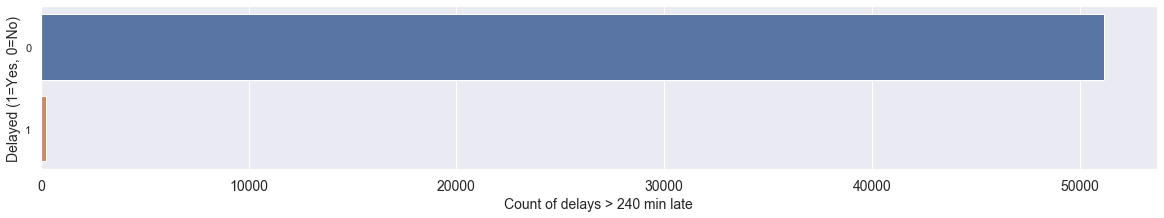

##########################################
Total flights   :  51376
Flights delayed :  228
Flights ontime  :  51148
##########################################
Flights delayed :  0.444 %
Flights ontime  :  99.556 %
##########################################


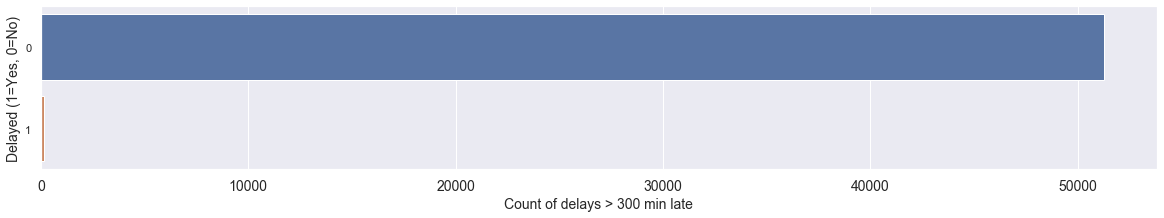

##########################################
Total flights   :  51376
Flights delayed :  131
Flights ontime  :  51245
##########################################
Flights delayed :  0.255 %
Flights ontime  :  99.745 %
##########################################


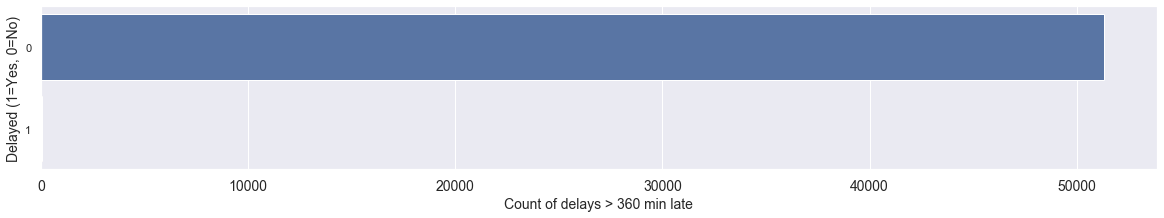

##########################################
Total flights   :  51376
Flights delayed :  78
Flights ontime  :  51298
##########################################
Flights delayed :  0.152 %
Flights ontime  :  99.848 %
##########################################


In [11]:
%time
# balanced class for delays at -4 minutes, ie take off 4 minutes early
cutoffs = (-5, -4, 0, 10, 20, 30, 60, 120, 180, 240, 300, 360)

for i in cutoffs:
    delay_cutoff_plot(i)

### 2.2.2 Class Imbalances for Cancelled and Delayed Flights

Two other insurable events are interesting in the flights dataset,
* Cancelled Flights
* Diverted Flights

##### Cancelled Flights = Target Variable
Delays can be inconvenient but cancelled flights on the day can be much more costly in time and money. Cancelled flights are  measurable and insurable, and the 1262 cancelled flights in the dataset represent 2.5% of the population.

Cancelled Flights will be our target variable.

##### Diverted Flights
Being diverted to Stanstead at 1am on Monday morning when your car is at Heathrow is a nightmare. This is very insurable event that speaks for itself. Fortunately for travellers only 0.25% of flights in the dataset were diverted, but the data is too small for us to take a meaningful look at.

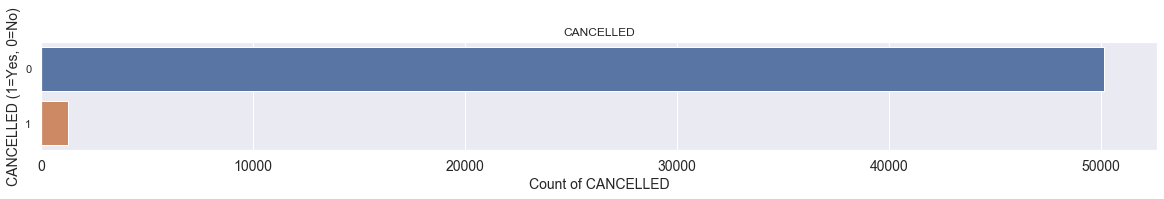

##########################################
Total flights         :  51375
Flights CANCELLED      :   1262
Flights not CANCELLED  :  50113
##########################################
% Flights CANCELLED    :  2.456 %
% Flights not CANCELLED: 97.544 %
##########################################


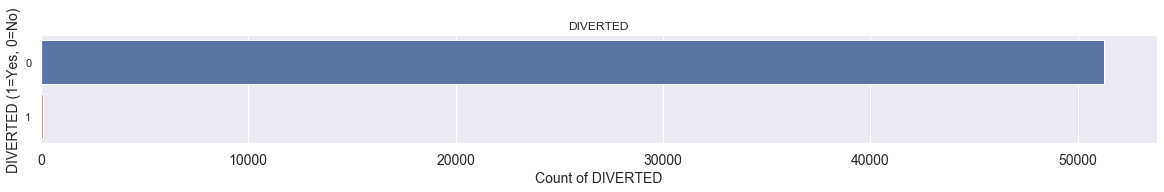

##########################################
Total flights         :  51375
Flights DIVERTED      :   120
Flights not DIVERTED  :  51255
##########################################
% Flights DIVERTED    :  0.234 %
% Flights not DIVERTED: 99.766 %
##########################################


In [12]:
cols = ('CANCELLED', 'DIVERTED')
for c in cols:
    classifier_plot(c)

In [13]:
## Define & Create Target Variable lateness
late = 10
df['DELAYED_TARGET'] = np.where(df['DEPARTURE_DELAY'] > late, 1, 0)

The chosen class lateness cutoff for flights is 10 minutes. The class imbalance is given below:

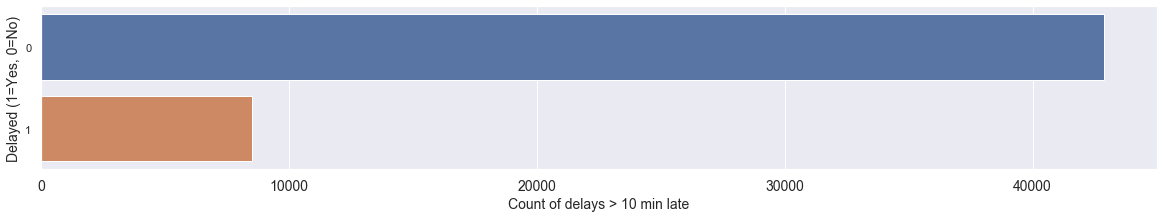

##########################################
Total flights   :  51376
Flights delayed :  8509
Flights ontime  :  42867
##########################################
Flights delayed :  16.562 %
Flights ontime  :  83.438 %
##########################################


In [14]:
delay_cutoff_plot(late)

In [15]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_STATE', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE', 'DELAYED_TARGET'],
      dtype='object')

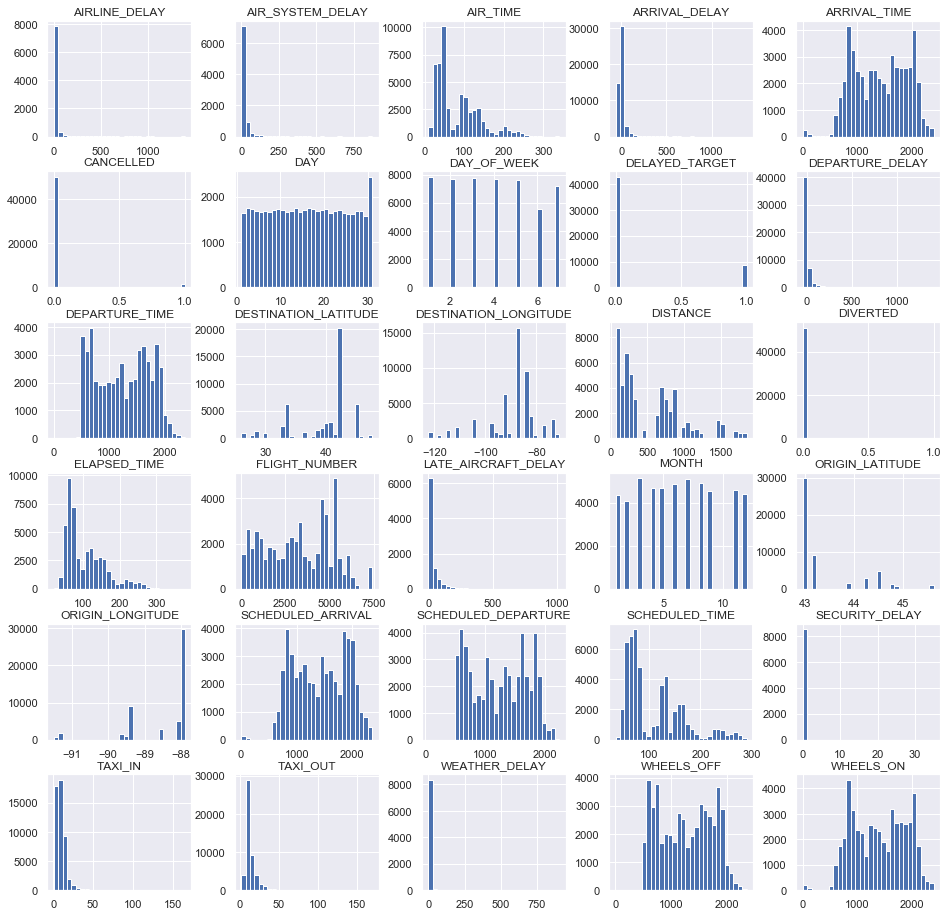

In [16]:
df.hist(bins=30, figsize=(16,16))
plt.show()

## 3.Data Cleaning

Some of the columns with NaNs need addressing. All cancelled flights and diverted flight were missing arrival times at their destination, so were replaced with 0 (no impact on analysis). Cancelled flights have no departure time, no wheels off, no arrival time so replaced with 0 (they can't be removed as there would be no cancelled flight data) Blank delays have been treated as no delay in the other columns. Uncancelled flights have no Cancellation Reason so NaNs replaced with 0s also. 

In [17]:
# replacing nan's
columns_to_clean = (
    'CANCELLATION_REASON',
    'AIR_SYSTEM_DELAY',
    'SECURITY_DELAY', 
    'AIRLINE_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'WEATHER_DELAY',
    'DEPARTURE_TIME',
    'DEPARTURE_DELAY',
    'TAXI_OUT',
    'WHEELS_OFF',
    'ELAPSED_TIME',
    'AIR_TIME',
    'WHEELS_ON',
    'TAXI_IN',
    'ARRIVAL_TIME',
    'ARRIVAL_DELAY',    
    'TAIL_NUMBER'
        )

for c in columns_to_clean:
        df[c] = df[c].replace('nan', np.nan).fillna(0)

In [18]:
target = 'DIVERTED'
corr_matrix = df.corr()
corr_matrix[target].sort_values(ascending=False)

DIVERTED                 1.000000
DEPARTURE_DELAY          0.029092
DELAYED_TARGET           0.025083
DISTANCE                 0.017864
SCHEDULED_TIME           0.017520
SCHEDULED_ARRIVAL        0.011236
WHEELS_OFF               0.009795
DEPARTURE_TIME           0.009399
TAXI_OUT                 0.009279
TAXI_IN                  0.008151
DESTINATION_LONGITUDE    0.006336
ORIGIN_LONGITUDE         0.006336
MONTH                    0.005688
DAY                      0.004941
SCHEDULED_DEPARTURE      0.004826
DAY_OF_WEEK              0.002191
SECURITY_DELAY          -0.000435
WEATHER_DELAY           -0.002565
WHEELS_ON               -0.003225
ARRIVAL_DELAY           -0.003479
ORIGIN_LATITUDE         -0.004741
AIRLINE_DELAY           -0.005119
ARRIVAL_TIME            -0.006535
FLIGHT_NUMBER           -0.007324
CANCELLED               -0.007678
AIR_SYSTEM_DELAY        -0.009363
LATE_AIRCRAFT_DELAY     -0.010356
DESTINATION_LATITUDE    -0.029117
AIR_TIME                -0.068825
ELAPSED_TIME  

### 3.1 Replacing Values

Named categorical variables can be changed to nummeric values with the help of dictionary comprehensions. 
This is particularly useful when the categories count is high and you don't wish to type out each mapping manually. 
Category names are stored in a list called "labels", zipped to a seqeunce of numbers and iterated over.

In [19]:
def names_categorical(col):
    '''Converts names in columns to numerical values, and change the data type to category'''
    labels = df[col].astype('category').cat.categories.tolist()
    replace_map_comp = {col : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
    df.replace(replace_map_comp, inplace=True)

In [20]:
categoricals = ('AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DESTINATION_STATE')#,'FLIGHT_NUMBER') # there are too many 'TAIL_NUMBER', 'FLIGHT_NUMBERSs!

for c in categoricals:
    names_categorical(c)                      

In [21]:
df.drop(columns=['airline_full_name',
       'ORIGIN_CITY', 'ORIGIN_STATE', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE',
       'DESTINATION_CITY', 'DESTINATION_LATITUDE',
       'DESTINATION_LONGITUDE'], inplace=True)

### 3.2 One Hot Encoding

The strategy is to convert each category value into a new column and assign a 1 or 0 (True/False) value to the column. This has the benefit of not weighting a value improperly.

There are many libraries out there that support one-hot encoding but the simplest one is using pandas' .get_dummies() method.
For this to work the categorical and numerical features must be identified and seperated into lists.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

#### 3.2.1 Splitting Out of Categorical Variables

In [22]:
cat_list = ['MONTH','DAY_OF_WEEK','AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DESTINATION_STATE', 'FLIGHT_NUMBER']    

In [23]:
for c in cat_list:
    df[c] = df[c].astype('category')

#### 3.2.2 Defining Numerical Variables

In [24]:
num_list = ['SCHEDULED_DEPARTURE',
            'LATE_AIRCRAFT_DELAY',
            'AIRLINE_DELAY',
            'WEATHER_DELAY',
            'AIR_SYSTEM_DELAY',
            'DISTANCE']

#### 3.3.3 Defining X and y

In [25]:
y = df[target]
X = df.drop(columns=[target])

In [26]:
num_features = X[num_list]
X_num = num_features
cat_features = X[cat_list]

#### 3.3.4 Perform One-Hot-Encoding

In [27]:
X_cat = pd.get_dummies(cat_features, columns=cat_list, drop_first=True)
X_cat.head(1)

,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_11,MONTH_12,...,FLIGHT_NUMBER_6599,FLIGHT_NUMBER_6629,FLIGHT_NUMBER_6640,FLIGHT_NUMBER_6681,FLIGHT_NUMBER_6741,FLIGHT_NUMBER_6824,FLIGHT_NUMBER_7402,FLIGHT_NUMBER_7414,FLIGHT_NUMBER_7415,FLIGHT_NUMBER_7416
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### 3.3.5 Perform Scaling

For the logistic regression model to be run in the next section, the data needed to be scaled. 

This increases the speed of optimisation, and is required when l1 and l2 penalties are aplied, as these will be dependent upon the relative size of the features. The transformation is done using StandardScaler.One 

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [28]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_num))

In [29]:
X_scaled.columns = num_list

#### 3.3.6 Rejoin nummeric and categorical variables

In [30]:
X = pd.concat([X_scaled, X_cat], axis=1)

## 4. Modelling
### 4.1. Train-Test split & KFold Validation

In order to be able to validate the model we had to split the dataset into train, validation and test segments: using the scikit learn train_test_split function:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)
print(pd.Series(y_train).value_counts())

0    41009
1       91
Name: DIVERTED, dtype: int64


In [32]:
X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_scaled, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)
print(pd.Series(y_train_initial).value_counts())

0    41009
1       91
Name: DIVERTED, dtype: int64


In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, 
                                                  y_train_initial, 
                                                  test_size=0.2,
                                                  random_state=42)

### 4.2 Using SMOTE to address Class Imbalance

SMOTE - Synthetic Minority Over-sampling Technique is used to address class imbalances, to improve model performance on minority classes.

https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [92]:
from imblearn.over_sampling import SMOTE, ADASYN

X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train_scaled, y) 

# Preview synthetic sample class distribution
print('SMOTE +++++++++++++++++++++')
print(pd.Series(y_train_resampled).value_counts()) 

NameError: name 'X_train_scaled' is not defined

In [35]:
%%time
from sklearn.metrics import roc_auc_score, roc_curve, auc

Wall time: 0 ns


In [36]:
%%time
skf = StratifiedKFold(n_splits=3,random_state=50)

Wall time: 0 ns


In [37]:
class Classification():
    ''' There are 4 types of models used in the class, Logistic Regression, Decision Tree, Random Forest, SVM'''
    def __init__(self, model, X_train_resampled, X_val, y_train_resampled, y_val):
        self.model = model
        self.X_train_resampled = X_train_resampled
        self.y_train_resampled = y_train_resampled
        self.X_val = X_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Logistic Regression':
            self.instantiate = LogisticRegression(fit_intercept=False, solver='liblinear') # don't need to balance due to SMOTE?
        elif self.model == 'Decision Tree':
            self.instantiate = DecisionTreeClassifier(random_state=42)
        elif self.model == 'Random Forest':
            self.instantiate = RandomForestClassifier(n_estimators=20, 
                                                          n_jobs=-1,
                                                          random_state=42)
        elif self.model == "SVM":
            self.instantiate = SVC(probability=True,
                                   random_state=42)
        
# SCORE FUNCTION -------------------------------------------------------------
        
    def scores(self, model, X_train_resampled, X_val, y_train_resampled, y_val):
        
        train_prob = model.predict_proba(X_train_resampled)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        
        train_auc = roc_auc_score(y_train_resampled, train_prob)
        val_auc = roc_auc_score(y_val, val_prob)
        
        self.train_auc = train_auc
        self.val_auc = val_auc
        
        self.scores_table = pd.DataFrame()
        
        self.scores_table["Model"] = [self.model]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]
        
        return self.scores_table
    
# THRESHOLD ANNOTATION -------------------------------------------------------

    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k % 100 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
            
# ROC PLOT FUNCTION ----------------------------------------------------------

    def roc_plot(model, X_train_resampled, X_val, y_train_resampled, y_val):
        train_prob = model.predict_proba(X_train_resampled)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        
        plt.figure(figsize=(5,5))
        for data in [[y_train_resampled, train_prob],[y_val, val_prob]]:
            fpr, tpr, thresh = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, thresh)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='-')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        
# GET SCORES FUNCTION --------------------------------------------------------

    def get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train_resampled, self.y_train_resampled)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        
        self.opt_model = opt_model.fit(self.X_train_resampled, self.y_train_resampled) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,
                                            self.best_model,
                                            self.X_train_resampled,
                                            self.X_val,
                                            self.y_train_resampled,
                                            self.y_val)
        
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best returned hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train_resampled,
                                                self.X_val,
                                                self.y_train_resampled,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
# OPTIMUM PLOT FUCNTION ------------------------------------------------------

    def opt_plots(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params, opt[cols]], axis=1, sort=False)
            
            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100) #can add cmap="Blues"
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,
                                       index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
            
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
# CONFUSION MATRIX FUNCTION --------------------------------------------------

    def conf_matrix(y_true, y_pred):
        
        con_mat = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    con_mat['TP'] += 1
                else:
                    con_mat['FN'] += 1
            else:
                if label == pred:
                    con_mat['TN'] += 1
                else:
                    con_mat['FP'] += 1
                
        return con_mat
        
# DISPLAY PRETTY CONFUSION MATRIX FUNCTION -----------------------------------

    def pretty_conf_matrix(self):
        
        Classification.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Blues)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

# PLOT DECISION TREE FUCNTION ------------------------------------------------

    def plot_dtree(self):
        
        if self.model == "Decision Tree" or self.model == "Random Forest":
            
            dot_data = StringIO()
            export_graphviz(self.best_model, 
                            out_file=dot_data, 
                            filled=True,
                            rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
            graph.write_png(f'{self.model}.png')
            image = mpimg.imread(f'{self.model}.png')
            plt.figure(figsize=(50,50))
            plt.imshow(image)
            plt.show()
            
        else:
            
            print("This model does not have a decision tree plot!")

# GET OPTIMUM THRESHOLD ------------------------------------------------------

  #  def get_threshold(self, prev, ctp, ctn, cfp, cfn):     

## 4.3 Logistic Regression

In [38]:
logistic_regression = Classification('Logistic Regression', X_train_resampled, X_val, y_train_resampled, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.693994,0.732167


The best returned hyperparameters are:  {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'} 



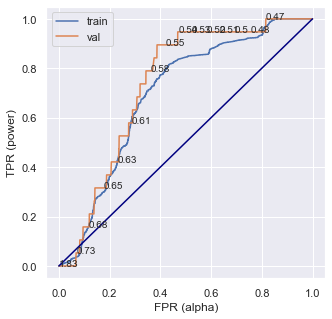

In [95]:
param_grid = {'C':[0.1,1, 10, 10**2, 10**3, 10**4], 
    'max_iter':[10, 100, 1000,],
    'penalty': ['l1', 'l2'],
    'solver':['lbfgs','liblinear','sag','saga']
}
logistic_regression.get_scores(param_grid, skf)

### 2nd Iteration: 
C = 0.1 is at the bottom of the range so adjust the search accordingly around 0.1 to include 0.01
max_iter = 10 and also at the bottom of the range, so adjusting search to include 5 & 20.
***ACTION FROM CALL WITH DAN***

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.69342,0.72985


The best returned hyperparameters are:  {'C': 0.01, 'max_iter': 5, 'penalty': 'l2', 'solver': 'sag'} 



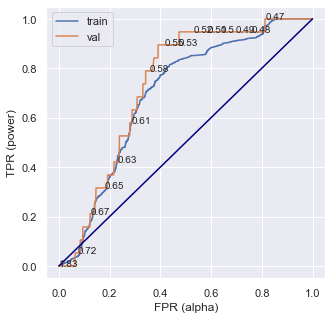

Wall time: 1min 15s


In [97]:
%%time
import time
time.sleep(3)

param_grid = {'C':[0.01, 0.1,1, 10, 10**2, 10**3], 
    'max_iter':[5, 10, 20, 50],
    'penalty': ['l1', 'l2'],
    'solver':['lbfgs','liblinear','sag','saga']
}
logistic_regression.get_scores(param_grid, skf)

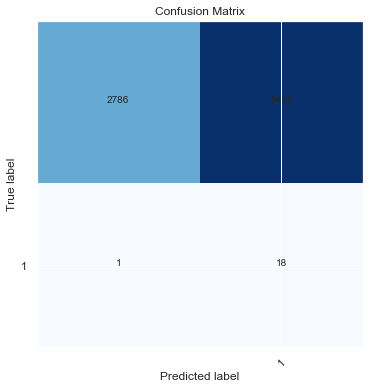

In [98]:
logistic_regression.pretty_conf_matrix()

### Third Iteration:
C was at 0.01 the lower bound of the range, setting a lower bound of 0.001 to reflect this.

Max iter was 5 again at the lower bound, setting a lower bound of 1 to reflect this.
***CHANGES REQUIRED BY DAN***

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.685853,0.728573


The best returned hyperparameters are:  {'C': 10, 'max_iter': 1, 'penalty': 'l1', 'solver': 'liblinear'} 



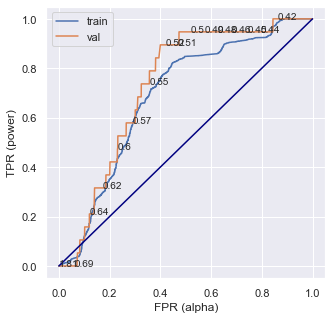

Wall time: 1min


In [118]:
%%time
import time
time.sleep(3)

param_grid = {'C':[0.001, 0.01, 0.1,1, 10, 10**2], 
    'max_iter':[1, 2, 3, 4, 5, 10],
    'penalty': ['l1', 'l2'],
    'solver':['lbfgs','liblinear','sag','saga']
}
logistic_regression.get_scores(param_grid, skf)

## 4.4. Decision Tree
### 4.4.1. Decision Tree Iteration 1

,Model,Train AUC,Validation AUC
0,Decision Tree,0.999673,0.614659


The best returned hyperparameters are:  {'max_depth': 50, 'min_samples_leaf': 10} 



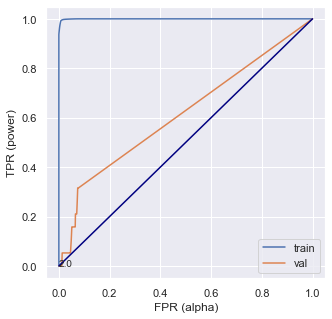

In [119]:
param_grid = {'max_depth':[15,20,25,50,100,200], 'min_samples_leaf':[10,100,150,200]}
decision_tree = Classification("Decision Tree", X_train_resampled, X_val, y_train_resampled, y_val)
decision_tree.get_scores(param_grid, skf)

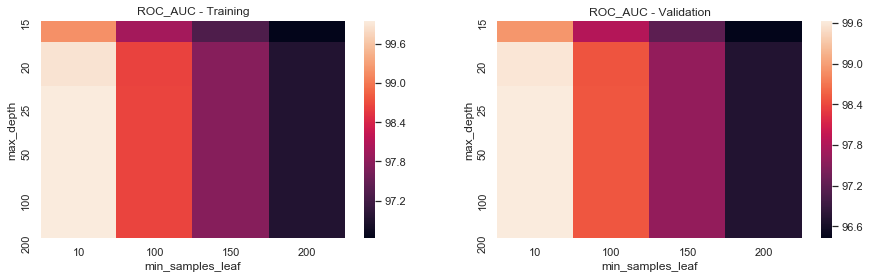

In [117]:
decision_tree.opt_plots()

## 2nd Iteration

The best parameters selected were max_depth = 50 & min_samples_leaf = 10
SEARCHING around the parameters 50 & 10

,Model,Train AUC,Validation AUC
0,Decision Tree,0.999584,0.60905


The best returned hyperparameters are:  {'max_depth': 30, 'min_samples_leaf': 13} 



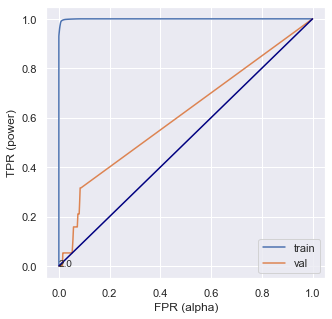

In [120]:
param_grid = {'max_depth':range(30,60,2), 'min_samples_leaf':range(10,20,1)}
decision_tree_2 = Classification("Decision Tree", X_train_resampled, X_val, y_train_resampled, y_val)
decision_tree_2.get_scores(param_grid, skf)

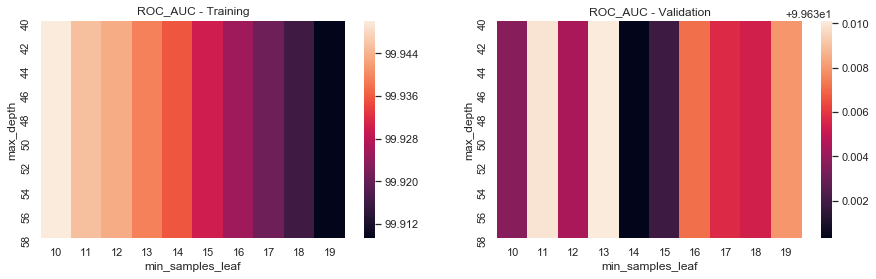

In [103]:
decision_tree_2.opt_plots()

### Third Iteration:
Inputs were max_depth = 30 & min_samples_leaf = 13.
Max depth at lower bound, so lowering to 20 and increasing granularity.

,Model,Train AUC,Validation AUC
0,Decision Tree,0.999433,0.611697


The best returned hyperparameters are:  {'max_depth': 22, 'min_samples_leaf': 11} 



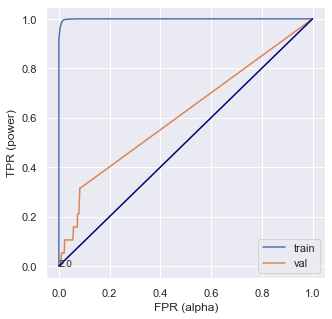

In [121]:
param_grid = {'max_depth':range(20,40,1), 'min_samples_leaf':range(8,18,1)}
decision_tree_3 = Classification("Decision Tree", X_train_resampled, X_val, y_train_resampled, y_val)
decision_tree_3.get_scores(param_grid, skf)

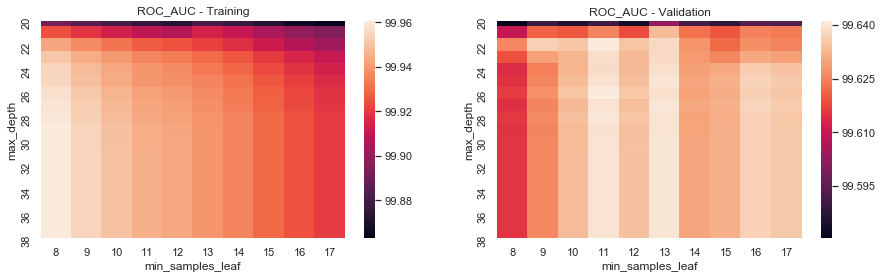

In [122]:
decision_tree_3.opt_plots()

## 4.5. Random Forest
### 4.5.1. Random Forest Iteration 1

,Model,Train AUC,Validation AUC
0,Random Forest,0.999791,0.619138


The best returned hyperparameters are:  {'max_depth': 100, 'min_samples_leaf': 1} 



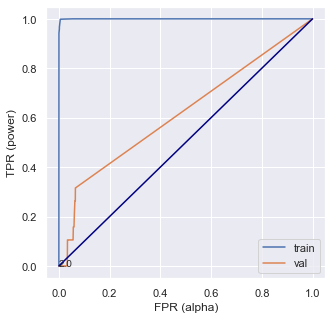

In [123]:
param_grid = {'max_depth':[1,10,100,1000], 'min_samples_leaf':[1,10,100,1000]}
random_forest = Classification("Random Forest", X_train_resampled, X_val, y_train_resampled, y_val)
random_forest.get_scores(param_grid, skf)

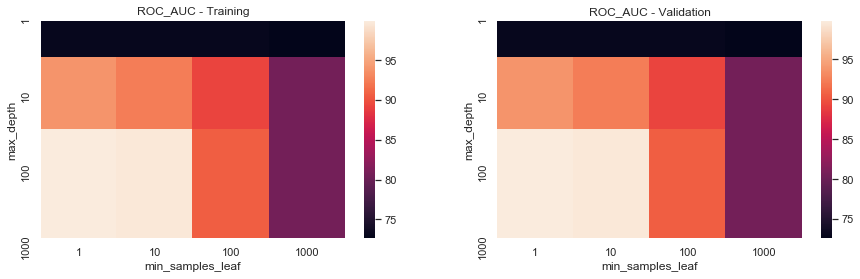

In [124]:
random_forest.best_model
random_forest.opt_plots()

### 4.5.2. Random Forest Iteration 2

Max depth 10 & number of leaves = 10 were selected, so are sweeping around them

In [ ]:
param_grid = {'max_depth':range(7, 13, 1), 'min_samples_leaf':range(7,13,1)}
random_forest2 = Classification("Random Forest", X_train_resampled, X_val, y_train_resampled, y_val)
random_forest2.get_scores(param_grid, skf)

In [ ]:
random_forest2.opt_plots()

## Ensemble Class

### 4.6. Ensemble Class

In [ ]:
class Ensemble(Classification):
    
    def __init__(self, ensemble_method, estimators, X_train_resampled, X_val, y_train_resampled, y_val):
        
        self.ensemble_method = ensemble_method
        self.X_train_resampled = X_train_resampled
        self.y_train_resampled = y_train_resampled
        self.X_val = X_val
        self.y_val = y_val
        
        if self.ensemble_method == "Voting":
            self.instantiate = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
        elif self.ensemble_method == "AdaBoost":
            self.instantiate = AdaBoostClassifier(estimators, algorithm='SAMME', n_estimators=20)
        elif self.ensemble_method == "XGBoost":
            self.instantiate = XGBClassifier(n_jobs=-1)
        elif self.ensemble_method == "Stacking":
            self.instantiate = StackingClassifier(estimators)
            
    def ensemble_scores(self):

        train_prob = self.instantiate.predict_proba(self.X_train_resampled)[:,1]
        val_prob = self.instantiate.predict_proba(self.X_val)[:,1]

        train_auc = roc_auc_score(self.y_train_resampled, train_prob)
        val_auc = roc_auc_score(self.y_val, val_prob)

        self.train_auc = train_auc
        self.val_auc = val_auc

        self.scores_table = pd.DataFrame()

        self.scores_table["Model"] = [self.ensemble_method]
        self.scores_table["Train AUC"] = [self.train_auc]
        self.scores_table["Validation AUC"] = [self.val_auc]

        return self.scores_table
    
    def ensemble_get_scores(self, param_grid, cv_type):
        reg = self.instantiate
        fit_reg = reg.fit(self.X_train_resampled, self.y_train_resampled)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.X_train_resampled, self.y_train_resampled) 
        self.best_model = opt_model.best_estimator_
        self.scores = Ensemble.ensemble_scores(self)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.X_train_resampled,
                                                self.X_val,
                                                self.y_train_resampled,
                                                self.y_val)
        self.y_predicted = opt_model.predict(self.X_val)
        
    def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm
    
    def ensemble_pretty_conf_matrix(self):
        
        Ensemble.conf_matrix(self.y_val, self.y_predicted)
        cnf_matrix = confusion_matrix(self.y_val, self.y_predicted)
        
        plt.figure(figsize=(6,6))
        plt.imshow(cnf_matrix, cmap=plt.cm.Blues)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

## 4.7. Voting Classifier¶

In [ ]:
log_reg = ('lr', logistic_regression.best_model)
dtree = ('dt', decision_tree.best_model)
rand_forest = ('rnd', random_forest.best_model)
estimators = [log_reg, dtree, rand_forest]

In [ ]:
voting = Ensemble("Voting", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
voting.ensemble_get_scores({}, skf)

In [ ]:
voting.ensemble_pretty_conf_matrix()

## 4.8. AdaBoost
### 4.8.1. AdaBoost - Logistic Regression

In [ ]:
estimators = logistic_regression.best_model
adaboost1 = Ensemble("AdaBoost", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
adaboost1.ensemble_get_scores({}, skf)

In [ ]:
adaboost1.ensemble_pretty_conf_matrix()

In [ ]:
estimators = decision_tree.best_model
adaboost2 = Ensemble("AdaBoost", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
adaboost1.ensemble_get_scores({}, skf)

### 4.8.3. AdaBoost - Random Forest

In [ ]:
estimators = random_forest.best_model
adaboost3 = Ensemble("AdaBoost", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
adaboost3.ensemble_get_scores({}, skf)

### 4.8.4. AdaBoost - Voting Classifier

In [ ]:
estimators = voting.best_model
adaboost4 = Ensemble("AdaBoost", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
adaboost4.ensemble_get_scores({}, skf)

In [ ]:
adaboost4.ensemble_pretty_conf_matrix()

### 4.9 Stacking

In [ ]:
estimators = [('lr',logistic_regression.best_model), 
              ('dt', decision_tree.best_model), 
              ('rnd', random_forest.best_model)]
stacking = Ensemble("Stacking", estimators, X_train_resampled, X_val, y_train_resampled, y_val)

In [ ]:
stacking.ensemble_get_scores({}, skf)

In [ ]:
stacking.ensemble_pretty_conf_matrix()

## 5. Model Evaluation
### 5.1 Feature Importance

In [ ]:
final_model = random_forest.best_model

In [ ]:
feature_importance = pd.DataFrame(final_model.feature_importances_)

In [ ]:
feature_importance.rename(columns={0:'Importance'}, inplace=True)

In [ ]:
feature_importance['Feature'] = X_scaled.columns

In [ ]:
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
feature_importance.head(20)

In [ ]:
top_20_features = feature_importance.head(20)

In [ ]:
plt.figure(figsize=(16,10))
sns.barplot(x='Feature', y='Importance', data=top_20_features, palette="Blues_d")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Importance', fontsize=14)
plt.show()

### Straight from the Lab if needed

In [ ]:
### SMOTE from the labs

%time
import time
time.sleep(3)

# Now let's compare a few different ratios of minority class to majority class
ratios = [0.05,0.1,0.25, 0.33, 0.5, 0.7, 1]
names = ['0.05','0.1','0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)
    y_score = logreg.decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()